In [1]:
# This tells matplotlib not to try opening a new window for each plot.
%matplotlib inline

# General libraries.
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# SK-learn libraries for learning.
from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LinearRegression
from sklearn.naive_bayes import BernoulliNB
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier 
from sklearn.ensemble import AdaBoostClassifier 
from sklearn import svm
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error

from sklearn.mixture import GaussianMixture
from sklearn.cluster import KMeans

from sklearn.decomposition import PCA

# SK-learn libraries for evaluation.
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import classification_report

# SK-learn library for importing the newsgroup data.
from sklearn.datasets import fetch_20newsgroups

# SK-learn libraries for feature extraction from text.
from sklearn.feature_extraction.text import *

import nltk
import xlsxwriter
import openpyxl
import os.path
from os.path import exists

import cv2
from skimage import io

import imageio  
import os

# Set the randomizer seed so results are the same each time.
np.random.seed(0)

In [2]:
#UPLOAD CONSOLIDATED TABLE WITH FEATURES
conso_filename = "data_consolidated.csv"
directory = "../data/"
df_data1 = pd.read_csv(directory+conso_filename)
print(len(list(df_data1.columns)))
df_data = df_data1.copy()

497


In [3]:
#STARTING AT 1
#FUNCTIONS USED TO CREATED DIFFERENT SCALES (1 TO 10, 1 TO 5, 1 TO 4, 1 TO 3, 1 TO 2)
def scale10(n):
    val = 0
    if n <=10: 
        val = 1
    elif n >10 and n<=20:
        val = 2
    elif n >20 and n <=30:
        val = 3
    elif n>30 and n <=40:
        val = 4
    elif n > 40 and n<=50:
        val = 5
    elif n>50 and n<=60:
        val = 6
    elif n>60 and n<=70:
        val = 7
    elif n>70 and n<=80:
        val = 8
    elif n>80 and n<=90:
        val = 9
    else: 
        val = 10
    return(val)

def scale5(n):
    val = 0
    if n <=20: 
        val = 1
    elif n >20 and n<=40:
        val = 2
    elif n >40 and n <=60:
        val = 3
    elif n>60 and n <=80:
        val = 4
    else: val = 5

    return(val)

def scale4(n):
    val = 0
    if n <=25: 
        val = 1
    elif n >25 and n<=50:
        val = 2
    elif n >50 and n <=75:
        val = 3
    else: 
        val = 4

    return(val)

def scale3(n):
    val = 0
    if n <=34: 
        val = 1
    elif n >34 and n<=68:
        val = 2
    else:
        val = 3

    return(val)

def scale2(n):
    val = 0
    if n < 50: 
        val = 1
    else:
        val = 2

    return(val)

In [4]:
#CREATE COLUMNS WITH DIFFERENT SCALES FOR TESTING MODELS
df_data["Scale10"] = df_data.apply(lambda row: scale10(row.Pawpularity), axis=1)
df_data["Scale5"] = df_data.apply(lambda row: scale5(row.Pawpularity), axis=1)
df_data["Scale4"] = df_data.apply(lambda row: scale4(row.Pawpularity), axis=1)
df_data["Scale3"] = df_data.apply(lambda row: scale3(row.Pawpularity), axis=1)
df_data["Scale2"] = df_data.apply(lambda row: scale2(row.Pawpularity), axis=1)

In [5]:
#To select the SCALE you want to work with (10, 5, 4, 3, 2)
def assign_y(scale):
    if scale == 2:
        Y_train = train_y2
        Y_dev = dev_y2
    elif scale == 3:
        Y_train = train_y3
        Y_dev = dev_y3
    elif scale == 4:
        Y_train = train_y4
        Y_dev = dev_y4
    elif scale == 5:
        Y_train = train_y5
        Y_dev = dev_y5
    elif scale == 10:
        Y_train = train_y10
        Y_dev = dev_y10
    elif scale == 100:
        Y_train = train_labels
        Y_dev = dev_labels
    else:
        Y_train = train_labels
        Y_dev = dev_labels
    return(Y_train, Y_dev)   

#Return list of mean for each range in scale
def mean_scale(scale, Y_train, train_labels):
    means = []
    start = 1
    for i in range(start,scale+start):
        index_to_get = np.where(Y_train == i)
        me = train_labels[index_to_get].mean()
        means.append(me)
    return(means)  

#Return list of mean for each range in scale
def mean_scale1(scale, Y_train, train_labels,f):
    meantot = train_labels.mean()
    means = []
    start = 1
    for i in range(start,scale+start):
        index_to_get = np.where(Y_train == i)
        me = train_labels[index_to_get].mean()
        means.append(((me+meantot)/2) + f)
    return(means)  

#Return Prediction based on mean for range in scale
def predict_scale(prediction, mean_scale):
    start = 1
    predict_out = []
    n = len(mean_scale)
    for p in prediction:
        predict_out.append(mean_scale[p-start])
    return(predict_out)

def print_confusion_matrix(Y_dev, Prediction, title):
    cfm = confusion_matrix(Y_dev,Prediction)
    start = 0 #It does not work
    size = 8
    if np.unique(Y_dev).max() > 5:
        size = 6
    else: 
        size = 3
    fig, ax = plt.subplots(figsize=(size, size))
    ax.matshow(cfm, cmap=plt.cm.Blues, alpha=0.3)
    for i in range(cfm.shape[0]):
        for j in range(cfm.shape[1]):
            ax.text(x=j+start, y=i+start,s=cfm[i, j], va='center', ha='center', size='xx-large')
    ax.set_title(title)

### Exploring Basic Features

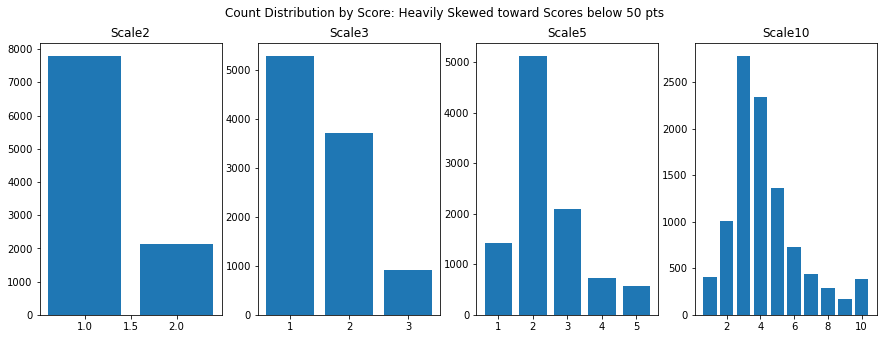

In [6]:
#Set subplot matrix
fig1, ax = plt.subplots(nrows=1, ncols=4, figsize=(15, 5))
scales_plot = [2, 3, 5, 10]
fontsize=12
i = 0
for s in scales_plot:
    if s == 100:
        sca = 'Pawpularity'
    else: sca = 'Scale'+str(s)
    df_scale = pd.pivot_table(df_data, index = sca, values = 'Id', aggfunc='count')
    ax[i].bar(list(df_scale.index),list(df_scale['Id']))
    ax[i].set_title(sca, fontsize=fontsize)
    i += 1
fig1.suptitle("Count Distribution by Score: Heavily Skewed toward Scores below 50 pts")
plt.show()

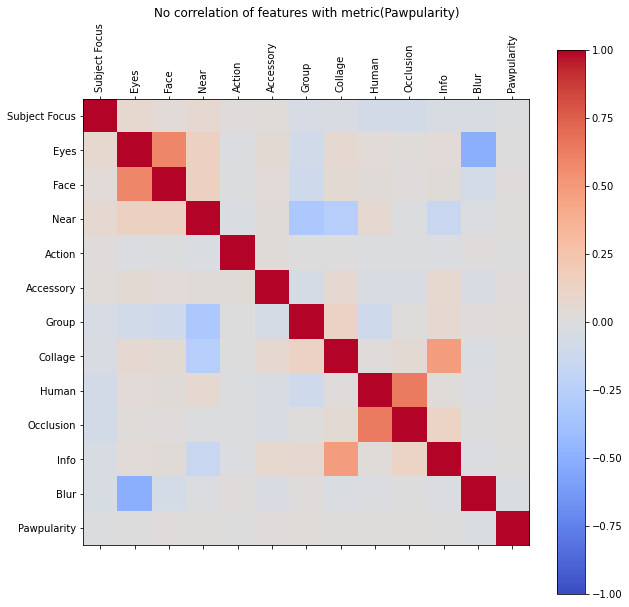

In [7]:
column_names = list(df_data.columns)
coln1 = 2
coln2 = coln1+12
basic_features = column_names[coln1:coln2]

sca = 'Pawpularity'
features = basic_features + [sca]
data = df_data[features]
corr = data.corr()
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111)
cax = ax.matshow(corr,cmap='coolwarm', vmin=-1, vmax=1)
fig.colorbar(cax)
ticks = np.arange(0,len(data.columns),1)
ax.set_xticks(ticks)
plt.xticks(rotation=90)
ax.set_yticks(ticks)
ax.set_xticklabels(data.columns)
ax.set_yticklabels(data.columns)
plt.title("No correlation of features with metric(Pawpularity)")
plt.show()

In [ ]:
#corr.style.background_gradient(cmap='coolwarm')

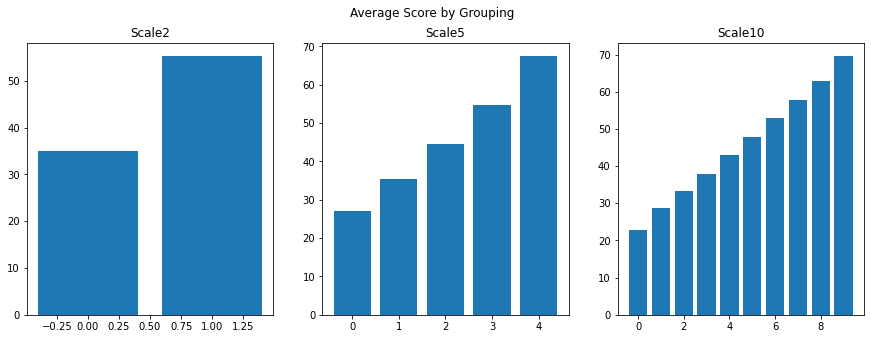

In [8]:
#Set subplot matrix
fig2, ax1 = plt.subplots(nrows=1, ncols=3, figsize=(15, 5))
scales_plot = [2, 5, 10]
fontsize=12
i = 0
for s in scales_plot:
    sca = 'Scale'+str(s)
    means = mean_scale1(s, np.array(df_data[sca]), np.array(df_data["Pawpularity"]),1.333)
    ax1[i].bar(range(0,s),np.array(means))
    ax1[i].set_title(sca, fontsize=fontsize)
    i += 1
fig2.suptitle("Average Score by Grouping")
plt.show()

### Color Pallet

In [9]:
def find_palette(img):
    
    # Then we can calculate the mean of each chromatic channel following a method analog to the one proposed by @Ruan B.:
    average = img.mean(axis=0).mean(axis=0)
    
    pixels = np.float32(img.reshape(-1, 3))

    n_colors = 5
    criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 200, .1)
    flags = cv2.KMEANS_RANDOM_CENTERS

    _, labels, palette = cv2.kmeans(pixels, n_colors, None, criteria, 10, flags)
    _, counts = np.unique(labels, return_counts=True)
    
    dominant = palette[np.argmax(counts)]
    
    avg_patch = np.ones(shape=img.shape, dtype=np.uint8)*np.uint8(average)
    
    indices = np.argsort(counts)[::-1]   
    freqs = np.cumsum(np.hstack([[0], counts[indices]/float(counts.sum())]))
    rows = np.int_(img.shape[0]*freqs)
    
#    dom_patch = np.zeros(shape=img.shape, dtype=np.uint8)
#    for i in range(len(rows) - 1):
#        dom_patch[rows[i]:rows[i + 1], :, :] += np.uint8(palette[indices[i]])
    
    return (dominant, average, palette, counts)

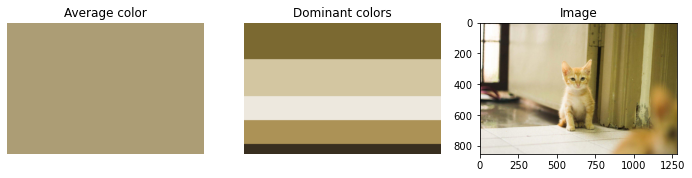

In [10]:
folder = "../data/train/"
#image_name = "00a1ae8867e0bb89f061679e1cf29e80.jpg"
image_name = "00a1e0c0f89ff89a8f32d42e9025f6b2.jpg"

#img = io.imread(image_name)[:, :, :-1]
img = io.imread(folder+image_name)

d, average, palette, counts = find_palette(img)
avg_patch = np.ones(shape=img.shape, dtype=np.uint8)*np.uint8(average)
dom_patch = np.zeros(shape=img.shape, dtype=np.uint8)
indices = np.argsort(counts)[::-1]   
freqs = np.cumsum(np.hstack([[0], counts[indices]/float(counts.sum())]))
rows = np.int_(img.shape[0]*freqs)

for i in range(len(rows) - 1):
    dom_patch[rows[i]:rows[i + 1], :, :] += np.uint8(palette[indices[i]])
    
fig, (ax0, ax1, ax2) = plt.subplots(1, 3, figsize=(12,6))
ax0.imshow(avg_patch)
ax0.set_title('Average color')
ax0.axis('off')
ax1.imshow(dom_patch)
ax1.set_title('Dominant colors')
ax2.imshow(img)
ax2.set_title('Image')
ax1.axis('off')
plt.show(fig)

### Palette Analysis

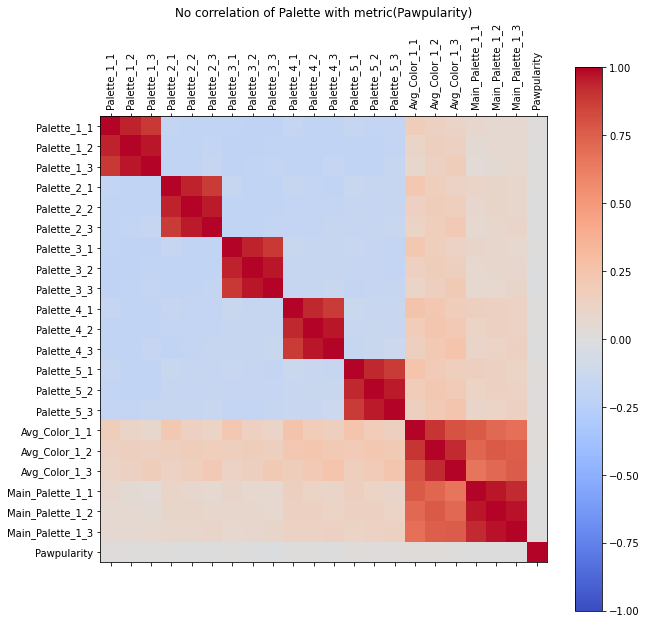

In [11]:
#Top Five Colors for Each Image + Average Color + Most Common Color
column_names = list(df_data.columns)
gap = 21
coln1 = len(column_names) - gap -5
coln2 = coln1 + gap

palette_to_keep = column_names[coln1:coln2]
sca = 'Pawpularity'
features = palette_to_keep + [sca]
data = df_data[features]
corr = data.corr()
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111)
cax = ax.matshow(corr,cmap='coolwarm', vmin=-1, vmax=1)
fig.colorbar(cax)
ticks = np.arange(0,len(data.columns),1)
ax.set_xticks(ticks)
plt.xticks(rotation=90)
ax.set_yticks(ticks)
ax.set_xticklabels(data.columns)
ax.set_yticklabels(data.columns)
plt.title("No correlation of Palette with metric(Pawpularity)")
plt.show()

### Exploring Augmented Data

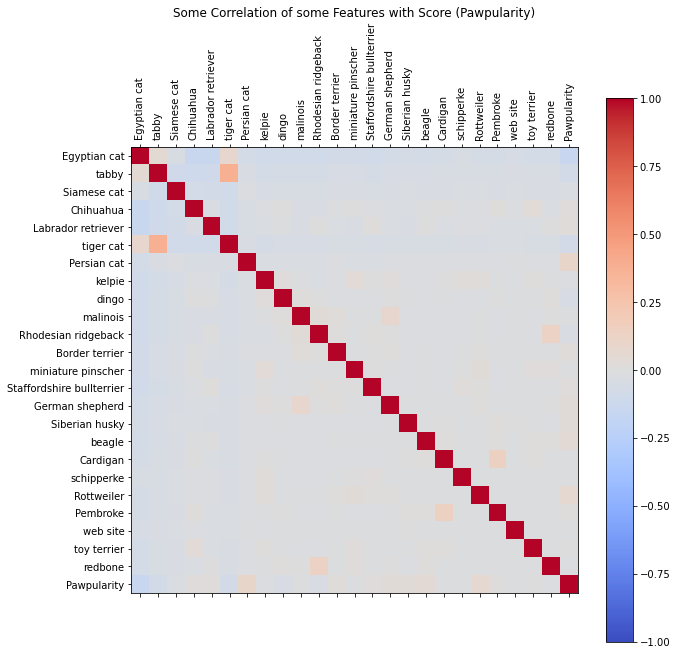

In [13]:
filename = "train_augmented_reduced.csv"
df_augmented = pd.read_csv("../data/"+filename)
takeout1 = ['Unnamed: 0', 'Id','Subject Focus', 'Eyes', 'Face', 'Near', 'Action', 'Accessory', 'Group',
            'Collage', 'Human', 'Occlusion', 'Info', 'Blur', 'Pawpularity',]
dff1 = df_augmented.drop(takeout1, axis=1)
dff1["id_max"] = dff1.idxmax(axis=1)
fcount = pd.DataFrame(dff1["id_max"].value_counts())
fcount = fcount.reset_index()
fcount.columns = ["name", "count"]
sf_select = fcount[fcount['count'] >80]
sf_selected = list(sf_select['name'])

sca = 'Pawpularity'
features = sf_selected + [sca]
data = df_data[features]
corr = data.corr()
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111)
cax = ax.matshow(corr,cmap='coolwarm', vmin=-1, vmax=1)
fig.colorbar(cax)
ticks = np.arange(0,len(data.columns),1)
ax.set_xticks(ticks)
plt.xticks(rotation=90)
ax.set_yticks(ticks)
ax.set_xticklabels(data.columns)
ax.set_yticklabels(data.columns)
plt.title("Some Correlation of some Features with Score (Pawpularity)")
plt.show()

### Selecting Features to Progress

In [14]:
column_names = list(df_data.columns)

coln1 = 2
coln2 = coln1+12
basic_features = column_names[coln1:coln2]

gap = 21
coln1 = len(column_names) - gap -5
coln2 = coln1 + gap

palette_to_keep = column_names[coln1:coln2]

to_keep = basic_features + sf_selected

print(len(to_keep))

36


### Splitting Data

In [15]:
#Get X and Y data - shuffle data.
X = np.array(df_data[to_keep])

#Use to take out columns
#X = np.array(df_data.drop(to_take_out, axis=1))

Y = df_data['Pawpularity'].values[:]

id_image = df_data['Id'].values[:]

Y10 = df_data['Scale10'].values[:]
Y5 = df_data['Scale5'].values[:]
Y4 = df_data['Scale4'].values[:]
Y3 = df_data['Scale3'].values[:]
Y2 = df_data['Scale2'].values[:]


shuffle = np.random.permutation(np.arange(X.shape[0]))
X, Y, id_image = X[shuffle], Y[shuffle], id_image[shuffle]
Y10, Y5, Y4, Y3, Y2 = Y10[shuffle], Y5[shuffle], Y4[shuffle], Y3[shuffle], Y2[shuffle]

# Define sizes for train, development and test data (0.5, 0.2, 0.3)
per_train = 0.80
per_dev = 0.18

num_images = len(Y)
train_size = int(round(num_images * per_train,0))
dev_size = int(round(num_images * per_dev,0))

# Split data based on defined sizes
test_data, test_labels, id_test = X[train_size+dev_size:], Y[train_size+dev_size:], id_image[train_size+dev_size:]
test_y10 = Y10[train_size+dev_size:]
test_y5 = Y5[train_size+dev_size:]
test_y4 = Y4[train_size+dev_size:]
test_y3 = Y3[train_size+dev_size:]
test_y2 = Y2[train_size+dev_size:]

dev_data, dev_labels, id_dev = X[train_size:train_size+dev_size], Y[train_size:train_size+dev_size], id_image[train_size:train_size+dev_size]
dev_y10 = Y10[train_size:train_size+dev_size]
dev_y5 = Y5[train_size:train_size+dev_size]
dev_y4 = Y4[train_size:train_size+dev_size]
dev_y3 = Y3[train_size:train_size+dev_size]
dev_y2 = Y2[train_size:train_size+dev_size]

train_data, train_labels, id_train = X[:train_size], Y[:train_size], id_image[:train_size]
train_y10 =  Y10[:train_size]
train_y5 =  Y5[:train_size]
train_y4 =  Y4[:train_size]
train_y3 =  Y3[:train_size]
train_y2 =  Y2[:train_size]

print(num_images)
print(train_data.shape, train_labels.shape, id_train.shape)
print(dev_data.shape, dev_labels.shape, id_dev.shape)
print(test_data.shape, test_labels.shape, id_test.shape)
print(test_y10.shape, dev_y10.shape, train_y10.shape)
print(test_y5.shape, dev_y5.shape, train_y5.shape)
print(test_y4.shape, dev_y4.shape, train_y4.shape)
print(test_y3.shape, dev_y3.shape, train_y3.shape)
print(test_y2.shape, dev_y2.shape, train_y2.shape)

9912
(7930, 36) (7930,) (7930,)
(1784, 36) (1784,) (1784,)
(198, 36) (198,) (198,)
(198,) (1784,) (7930,)
(198,) (1784,) (7930,)
(198,) (1784,) (7930,)
(198,) (1784,) (7930,)
(198,) (1784,) (7930,)


### Minimum Accuracy Score - RMSE when prediction is the average

In [16]:
scale = 100
Y_train, Y_dev = assign_y(scale)
avg_dev = Y_dev.mean()
print(avg_dev)
print(Y_dev.shape)

basic_prediction = np.repeat(avg_dev, Y_dev.shape[0])
rmse = np.sqrt(mean_squared_error(basic_prediction, dev_labels))
print(rmse)

37.815582959641254
(1784,)
20.034755770553296


### Basic Model Prediction

#### KNN

[25.654145817758234, 31.342434728694204, 35.990437262566545, 40.54339712426829, 45.54398020065962, 50.641338036932865, 55.51945929507369, 60.43567245545339, 65.50985791911253, 72.32527383231326]
For K:  3 ,for scale  10 , accuracy:  0.2163677130044843
For K:  3 ,for scale  10 , f1_score:  0.19931321982290273
For K:  3 ,for scale  10 , MSME:  2.6099155528149014
For K:  3 ,for scale  10 , MSME(100):  20.83292620609576
20.034755770553296


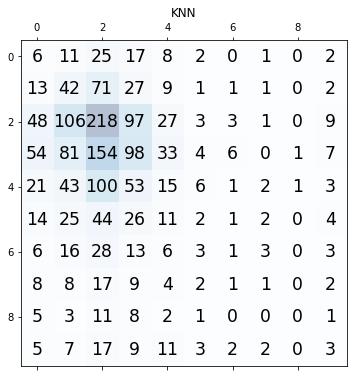

In [17]:
scale = 10
Y_train, Y_dev = assign_y(scale)
k = 3
f1 = 1.333
#f1 = 1
f = 3.0184739 * f1
#f = 0
means = mean_scale1(scale, Y_train, train_labels,f)
print(means)

# means[0] = 35.42
# means[1] = 62.08

# means[0] = 38.04819277108434
# means[1] = 38.04819277108434 + 3.0184739


metric_list = ['euclidean', 'manhattan', 'chebyshev', 'minkowski', 'wminkowski', 'seuclidean', 'mahalanobis']
metric = metric_list[1]

weights = ["uniform", "distance"]
algorithm_list = ["auto", "ball_tree", "kd_tree", "brute"]

knn_mod = KNeighborsClassifier(n_neighbors=k, algorithm=algorithm_list[0], weights=weights[0],  metric = metric)
knn_mod.fit(train_data, Y_train)
pred_knn = knn_mod.predict(dev_data)
accuracy =  knn_mod.score(dev_data, Y_dev)
f1_score = metrics.f1_score(Y_dev, pred_knn, average="weighted")
rmse = np.sqrt(mean_squared_error(pred_knn, Y_dev))

print("For K: ",k,",for scale ",scale,", accuracy: ",accuracy)
print("For K: ",k,",for scale ",scale,", f1_score: ",f1_score)
print("For K: ",k,",for scale ",scale,", MSME: ",rmse)

pre_scale = predict_scale(pred_knn, means)
rmse2 = np.sqrt(mean_squared_error(pre_scale, dev_labels))
print("For K: ",k,",for scale ",scale,", MSME(100): ",rmse2)
print(np.sqrt(mean_squared_error(basic_prediction, dev_labels)))

#Generate and create dataframe of Confusion Matrix
print_confusion_matrix(Y_dev, pred_knn, "KNN")

In [18]:
label = knn_mod.predict(train_data)
l2 = label.reshape(len(label),1)
regr = LinearRegression()
regr.fit(l2, train_labels)
print(regr.coef_)
print(regr.intercept_)

[5.44667992]
20.699135539795044


### KNN Classifier

In [19]:
def knn_model(train_data, train_labels, dev_data, dev_labels, algorithm, weigth, klist):
    
    f1_score = []
    
    for k in klist:
        knn_mod = KNeighborsClassifier(n_neighbors=k, algorithm=algorithm, weights=weigth, p=1)
        knn_mod.fit(train_data, train_labels)
        acc = knn_mod.score(dev_data, dev_labels)
        f1_score.append(metrics.f1_score(dev_labels, knn_mod.predict(dev_data), average="weighted"))
    
    return(f1_score)
    
def knn_models(train_data, Y_train, dev_data, Y_dev):
    df_knn = pd.DataFrame()
    klist = [1, 2, 3, 4, 5, 6, 7,8,9, 10, 11, 12, 13, 14, 15]
    algorithm_list = ["auto", "ball_tree", "kd_tree", "brute"]

    weights = ["uniform", "distance"]
    df_knn["K"] = klist

    for algorithm in algorithm_list:
        df_knn[algorithm] = knn_model(train_data, Y_train, dev_data, Y_dev, algorithm, weights[1], klist)
    print(df_knn)
    print("df_knn")
    return(df_knn)

### NB Classifier

In [20]:
def NB_model(train_data, train_labels, dev_data, Y_dev, dev_labels, alpha_list, means):
    f1_scoreL = []
    accuracyL = []
    rmseL = []
 
    for alpha in alpha_list:
        NB_mod = BernoulliNB(alpha=alpha)
        NB_mod.fit(train_data, train_labels)
        pred_NB = NB_mod.predict(dev_data)
        f1_scoreL.append(metrics.f1_score(Y_dev, pred_NB, average="weighted"))
        accuracyL.append(NB_mod.score(dev_data, Y_dev))  
        pre_scale = predict_scale(pred_NB, means)
        rmseL.append(np.sqrt(mean_squared_error(pre_scale, dev_labels)))
        
    return(accuracyL, f1_scoreL, rmseL)


def NB_models(train_data, Y_train, dev_data, Y_dev, dev_labels, means, scale):
    alpha_list = [1.0e-10, 0.0001, 0.001, 0.01, 0.1, 0.5, 1.0, 2.0, 10.0, 20, 30 ,20 ,30 ,100]

    df_NB = pd.DataFrame()
    df_NB["Alpha_"+str(scale)] = alpha_list
    accuracyL, f1_scoreL, rmseL, = NB_model(train_data, Y_train, dev_data, Y_dev, dev_labels, alpha_list, means)
    df_NB["Acc_NB"] = accuracyL
    df_NB["f1s_NB"] = f1_scoreL
    df_NB["RMSE_NB"] = rmseL
  
    return(df_NB)

In [21]:
f1 = 1.333
f = (3.0184739 * f1)
# f = 0

scale_list = [2, 3, 4, 5, 10, 100]
scale = 10
Y_train, Y_dev = assign_y(scale)

means = mean_scale1(scale, Y_train, train_labels, f)
#means = mean_scale(scale, Y_train, train_labels)
print(means)
# means[0] = 35.42
# means[1] = 62.08

# means[0] = 37.815582959641254
# means[1] = 37.815582959641254


df_NB_F = NB_models(train_data, Y_train, dev_data, Y_dev, dev_labels, means, scale)
df_NB_F

[25.654145817758234, 31.342434728694204, 35.990437262566545, 40.54339712426829, 45.54398020065962, 50.641338036932865, 55.51945929507369, 60.43567245545339, 65.50985791911253, 72.32527383231326]


,Alpha_10,Acc_NB,f1s_NB,RMSE_NB
0,1.000000e-10,0.289798,0.187481,20.081672
1,1.000000e-04,0.289798,0.187481,20.081672
2,1.000000e-03,0.289798,0.187481,20.081672
3,1.000000e-02,0.289798,0.187481,20.081672
4,1.000000e-01,0.289798,0.187481,20.081672
5,5.000000e-01,0.289798,0.187481,20.081672
6,1.000000e+00,0.289798,0.187488,20.078842
7,2.000000e+00,0.290359,0.187816,20.087127
8,1.000000e+01,0.293161,0.182511,20.101991
9,2.000000e+01,0.283632,0.156361,20.113131


### Multinomial NB

In [22]:
def MNB_model(train_data, train_labels, dev_data, Y_dev, dev_labels, alpha_list, means):
    
    f1_scoreL = []
    accuracyL = []
    rmseL = []
    
    for alpha in alpha_list:
        model = MultinomialNB(alpha=alpha)
        model.fit(train_data, train_labels)
        prediction = model.predict(dev_data)
        f1_scoreL.append(metrics.f1_score(Y_dev, prediction, average="weighted"))
        accuracyL.append(model.score(dev_data, Y_dev))  
        pre_scale = predict_scale(prediction, means)
        rmseL.append(np.sqrt(mean_squared_error(pre_scale, dev_labels)))
    
    return(accuracyL, f1_scoreL, rmseL)

def MNB_models(train_data, Y_train, dev_data, Y_dev, dev_labels, means, scale):
    alpha_list = [1.0e-10, 0.0001, 0.001, 0.01, 0.1, 0.5, 1.0, 2.0, 10.0]

    df_MNB = pd.DataFrame()
    df_MNB["Alpha_"+str(scale)] = alpha_list
    
    accuracyL, f1_scoreL, rmseL = MNB_model(train_data, Y_train, dev_data, Y_dev, dev_labels, alpha_list, means)
    df_MNB["Acc_MNB"] = accuracyL
    df_MNB["f1s_MNB"] = f1_scoreL
    df_MNB["RMSE_MNB"] = rmseL

    return(df_MNB)

In [ ]:
f1 = 1.333
f = (3.0184739 * f1)
# f = 0

scale_list = [2, 3, 4, 5, 10, 100]
scale = 10
Y_train, Y_dev = assign_y(scale)

means = mean_scale1(scale, Y_train, train_labels, f)
#means = mean_scale(scale, Y_train, train_labels)
print(means)
# means[0] = 35.42
# means[1] = 62.08

# means[0] = 37.815582959641254
# means[1] = 37.815582959641254


df_MNB_F = MNB_models(train_data, Y_train, dev_data, Y_dev, dev_labels, means, scale)
df_MNB_F

### Gaussian NB

In [23]:
def GNB_model(train_data, train_labels, dev_data, Y_dev, dev_labels, smoothing_list, means):
    
    f1_scoreL = []
    accuracyL = []
    rmseL = []
    
    for var_smoothing in smoothing_list:
        model = GaussianNB(var_smoothing=var_smoothing)
        model.fit(train_data, train_labels)
        prediction = model.predict(dev_data)
        f1_scoreL.append(metrics.f1_score(Y_dev, prediction, average="weighted"))
        accuracyL.append(model.score(dev_data, Y_dev))  
        pre_scale = predict_scale(prediction, means)
        rmseL.append(np.sqrt(mean_squared_error(pre_scale, dev_labels)))
     
    return(accuracyL, f1_scoreL, rmseL)

def GNB_models(train_data, Y_train, dev_data, Y_dev, dev_labels, means, scale):
    smoothing_list = [1.0e-10, 0.0001, 0.001, 0.01, 0.1, 0.5, 1.0, 2.0, 10.0]

    df = pd.DataFrame()
    df["Alpha_"+str(scale)] = smoothing_list
    
    accuracyL, f1_scoreL, rmseL = GNB_model(train_data, Y_train, dev_data, Y_dev, dev_labels, smoothing_list, means)
    df["Acc_MNB"] = accuracyL
    df["f1s_MNB"] = f1_scoreL
    df["RMSE_MNB"] = rmseL
    
    return(df)


In [ ]:
f1 = 1.333
f = (3.0184739 * f1)
# f = 0

scale_list = [2, 3, 4, 5, 10, 100]
scale = 2
Y_train, Y_dev = assign_y(scale)

means = mean_scale1(scale, Y_train, train_labels, f)
#means = mean_scale(scale, Y_train, train_labels)
print(means)
# means[0] = 35.42
# means[1] = 62.08

# means[0] = 37.815582959641254
# means[1] = 37.815582959641254


df_GNB_F = GNB_models(train_data, Y_train, dev_data, Y_dev, dev_labels, means, scale)
df_GNB_F

### LogisticRegression
Warning The choice of the algorithm depends on the penalty chosen: Supported penalties by solver:  
- ‘newton-cg’ - [‘l2’, ‘none’]  
- ‘lbfgs’ - [‘l2’, ‘none’]  
- ‘liblinear’ - [‘l1’, ‘l2’]  
- ‘sag’ - [‘l2’, ‘none’]  
- ‘saga’ - [‘elasticnet’, ‘l1’, ‘l2’, ‘none’]

**max_iter was increased to 200, so it would converge**
- max_iter int, default=100
- Maximum number of iterations taken for the solvers to converge.

In [24]:
def LogR_model(train_data, train_labels, dev_data, dev_labels, penalty, solver, c_list):
    
    
    #c_list = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1, 1.1, 1.2, 1.3, 1.4, 1.5]
    
    f1_score = []
    for c in c_list:
        logR_mod = LogisticRegression(C=c, solver=solver, multi_class="auto", penalty=penalty, max_iter=200)
        logR_mod.fit(train_data, train_labels)
        acc = logR_mod.score(dev_data, dev_labels)
        f1_score.append(metrics.f1_score(dev_labels, logR_mod.predict(dev_data), average="weighted"))
    return(f1_score)

def LogR_models(train_data, Y_train, dev_data, Y_dev):
    df_logR =pd.DataFrame()
    solver_list = ["liblinear", "newton-cg", "sag", "lbfgs"]
    c_list = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]

    df_logR["C"] = c_list
    for solver in solver_list:
        df_logR[solver] = LogR_model(train_data, Y_train, dev_data, Y_dev, "l2", solver, c_list)

    print(df_logR)
    print("df_LogR")
    return(df_logR)

### Tree

In [25]:
def DT_model(train_data, Y_train, dev_data, Y_dev, dev_labels, criterion, max_depth_list, means):
    
    f1_scoreL = []
    accuracyL = []
    rmseL = []
    
    for max_depth in max_depth_list:
        model = DecisionTreeClassifier(criterion=criterion, min_samples_split=10, max_depth=max_depth)
        model.fit(train_data, Y_train)
        prediction = model.predict(dev_data)
        f1_scoreL.append(metrics.f1_score(Y_dev, prediction, average="weighted"))
        accuracyL.append(model.score(dev_data, Y_dev))  
        pre_scale = predict_scale(prediction, means)
        rmseL.append(np.sqrt(mean_squared_error(pre_scale, dev_labels)))

    return(accuracyL, f1_scoreL, rmseL)

def DT_models(train_data, Y_train, dev_data, Y_dev, dev_labels, means, scale):
    df = pd.DataFrame()
    criterion_list = ["entropy", "gini"]
    max_depth_list = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]
    df["maxd_"+str(scale)] = max_depth_list

    for criterion in criterion_list:
        accuracyL, f1_scoreL, rmseL = DT_model(train_data, Y_train, dev_data, Y_dev, dev_labels, criterion, max_depth_list, means)
        df["Acc_"+criterion] = accuracyL
        df["f1s_"+criterion] = f1_scoreL
        df["RMSE_"+criterion] = rmseL
 
    return(df)

In [ ]:
f1 = 1.333
f = (3.0184739 * f1)
# f = 0

scale_list = [2, 3, 4, 5, 10, 100]
scale = 2
Y_train, Y_dev = assign_y(scale)

means = mean_scale1(scale, Y_train, train_labels, f)
#means = mean_scale(scale, Y_train, train_labels)
print(means)
# means[0] = 35.42
# means[1] = 62.08

# means[0] = 37.815582959641254
# means[1] = 37.815582959641254


df_DT_F = DT_models(train_data, Y_train, dev_data, Y_dev, dev_labels, means, scale)
df_DT_F

### Random Forest

In [26]:
def RF_model(train_data, train_labels, dev_data, Y_dev, dev_labels, criterion, n_estimators_list, means):
        
    f1_scoreL = []
    accuracyL = []
    rmseL = []
    
    for n_estimators in n_estimators_list:
        RF_model = RandomForestClassifier(n_estimators=n_estimators,criterion=criterion, min_samples_split=10)
        RF_model.fit(train_data, train_labels)
        pred_RF = RF_model.predict(dev_data)
        f1_scoreL.append(metrics.f1_score(Y_dev, RF_model.predict(dev_data), average="weighted"))
        accuracyL.append(RF_model.score(dev_data, Y_dev))  
        pre_scale = predict_scale(pred_RF, means)
        rmseL.append(np.sqrt(mean_squared_error(pre_scale, dev_labels)))
        
    return(accuracyL, f1_scoreL, rmseL)


def RF_models(train_data, Y_train, dev_data, Y_dev, dev_labels, means, scale):
    df_RF =pd.DataFrame()
    criterion_list = ["entropy", "gini"]
    n_estimators_list = [5, 10, 15, 20, 25, 30, 35, 40, 50, 55, 60, 80, 100]
    df_RF["n_est_"+str(scale)] = n_estimators_list
    for criterion in criterion_list:
        accuracyL, f1_scoreL, rmseL, = RF_model(train_data, Y_train, dev_data, Y_dev, dev_labels, criterion, n_estimators_list, means)
        df_RF["Acc_"+criterion] = accuracyL
        df_RF["f1s_"+criterion] = f1_scoreL
        df_RF["RMSE_"+criterion] = rmseL
        
    return(df_RF)

In [ ]:
f1 = 1.333
f = (3.0184739 * f1)
# f = 0

scale_list = [2, 3, 4, 5, 10, 100]
scale = 10
Y_train, Y_dev = assign_y(scale)

means = mean_scale1(scale, Y_train, train_labels, f)
#means = mean_scale(scale, Y_train, train_labels)
print(means)
# means[0] = 35.42
# means[1] = 62.08

# means[0] = 37.815582959641254
# means[1] = 37.815582959641254


df_RF = RF_models(train_data, Y_train, dev_data, Y_dev, dev_labels, means, scale)
df_RF

In [ ]:
dev_labels

### AdaBoost

In [27]:
def AdaB_model(train_data, train_labels, dev_data, Y_dev, dev_labels, algorithm, n_estimators_list, means):
        
    f1_scoreL = []
    accuracyL = []
    rmseL = []
    
    for n_estimators in n_estimators_list:
        AdaB_model = AdaBoostClassifier(n_estimators=n_estimators,algorithm=algorithm, learning_rate=1.2)
        AdaB_model.fit(train_data, train_labels)
        
        pred_AdaB = AdaB_model.predict(dev_data)
        f1_scoreL.append(metrics.f1_score(Y_dev, pred_AdaB, average="weighted"))
        accuracyL.append(AdaB_model.score(dev_data, Y_dev))  
        pre_scale = predict_scale(pred_AdaB, means)
        rmseL.append(np.sqrt(mean_squared_error(pre_scale, dev_labels)))

    return(accuracyL, f1_scoreL, rmseL)

def AdaB_models(train_data, Y_train, dev_data, Y_dev, dev_labels, means, scale):
    df_AdaB =pd.DataFrame()
    algorithm_list = ["SAMME", "SAMME.R"]
    n_estimators_list = [5, 10, 15, 20, 25, 30]
    df_AdaB["n_est_"+str(scale)] = n_estimators_list

    for algorithm in algorithm_list:
        accuracyL, f1_scoreL, rmseL = AdaB_model(train_data, Y_train, dev_data, Y_dev, dev_labels, algorithm, n_estimators_list, means)
        df_AdaB["Acc_"+algorithm] = accuracyL
        df_AdaB["f1s_"+algorithm] = f1_scoreL
        df_AdaB["RMSE_"+algorithm] = rmseL

    return(df_AdaB)

In [ ]:
# f1 = 1.333
# f = (3.0184739 * f1)
f = 0

scale_list = [2, 3, 4, 5, 10, 100]
scale = 2
Y_train, Y_dev = assign_y(scale)

means = mean_scale1(scale, Y_train, train_labels, f)
#means = mean_scale(scale, Y_train, train_labels)
print(means)
# means[0] = 35.42
# means[1] = 62.08

# means[0] = 37.815582959641254
# means[1] = 37.815582959641254


df_AdaB = AdaB_models(train_data, Y_train, dev_data, Y_dev, dev_labels, means, scale)
df_AdaB

### SVM

In [28]:
def SVM_model(train_data, train_labels, dev_data, Y_dev, dev_labels, kernel, c_list, means):
        
    f1_scoreL = []
    accuracyL = []
    rmseL = []
    
    for c in c_list:
        if kernel == "LinearSVC":
            svm_model = svm.LinearSVC(C=c, max_iter=10000)
        elif kernel == "poly":
            svm_model = svm.SVC(kernel=kernel, C=c, degree=2, gamma=1)
        elif kernel == "rbf":
            svm_model = svm.SVC(kernel=kernel, C=c, gamma=0.7)
        else:
            svm_model = svm.SVC(kernel=kernel, C=c,)
        
        svm_model.fit(train_data, train_labels)
        
        pred_SVM = svm_model.predict(dev_data)
        f1_scoreL.append(metrics.f1_score(Y_dev, pred_SVM, average="weighted"))
        accuracyL.append(svm_model.score(dev_data, Y_dev))  
        pre_scale = predict_scale(pred_SVM, means)
        rmseL.append(np.sqrt(mean_squared_error(pre_scale, dev_labels)))
 
    return(accuracyL, f1_scoreL, rmseL)

def SVM_models(train_data, Y_train, dev_data, Y_dev, dev_labels, means, scale):
    df_SVM =pd.DataFrame()
    kernel_list = ["linear", "rbf", "poly", "LinearSVC"]
    c_list = [0.5, 1, 1.5, 2, 2.5, 3, 4, 5, 10, 20]
    df_SVM["C_"+str(scale)] = c_list

    for kernel in kernel_list:
        accuracyL, f1_scoreL, rmseL = SVM_model(train_data, Y_train, dev_data, Y_dev, dev_labels, kernel, c_list, means)
        df_SVM["Acc_"+algorithm] = accuracyL
        df_SVM["f1s_"+algorithm] = f1_scoreL
        df_SVM["RMSE_"+algorithm] = rmseL

    return(df_SVM)

In [ ]:
f1 = 1.333
f = (3.0184739 * f1)
# f = 0

scale_list = [2, 3, 4, 5, 10, 100]
scale = 2
Y_train, Y_dev = assign_y(scale)

means = mean_scale1(scale, Y_train, train_labels, f)
#means = mean_scale(scale, Y_train, train_labels)
print(means)
# means[0] = 35.42
# means[1] = 62.08

# means[0] = 37.815582959641254
# means[1] = 37.815582959641254


df_SVM_F = SVM_models(train_data, Y_train, dev_data, Y_dev, dev_labels, means, scale)
df_SVM_F

### Neural Network

**hidden_layer_sizestuple, length = n_layers - 2, default=(100,)**  
The ith element represents the number of neurons in the ith hidden layer.

**activation{‘identity’, ‘logistic’, ‘tanh’, ‘relu’}, default=’relu’**  
Activation function for the hidden layer.  

- ‘identity’, no-op activation, useful to implement linear bottleneck, returns f(x) = x  
- ‘logistic’, the logistic sigmoid function, returns f(x) = 1 / (1 + exp(-x)).  
- ‘tanh’, the hyperbolic tan function, returns f(x) = tanh(x).   
- ‘relu’, the rectified linear unit function, returns f(x) = max(0, x)  

**solver{‘lbfgs’, ‘sgd’, ‘adam’}, default=’adam’**  
The solver for weight optimization.  

- ‘lbfgs’ is an optimizer in the family of quasi-Newton methods.
- ‘sgd’ refers to stochastic gradient descent.
- ‘adam’ refers to a stochastic gradient-based optimizer proposed by Kingma, Diederik, and Jimmy Ba

Note: The default solver ‘adam’ works pretty well on relatively large datasets (with thousands of training samples or more) in terms of both training time and validation score. For small datasets, however, ‘lbfgs’ can converge faster and perform better.

**alphafloat, default=0.0001**
L2 penalty (regularization term) parameter.

In [29]:
def NN_model(train_data, train_labels, dev_data, Y_dev, dev_labels, activation, solver_list, alpha_list, layer_list, choice, means):
        
    f1_scoreL = []
    accuracyL = []
    rmseL = []
    
    if choice == "A":
        for alpha in alpha_list:
            NN_model = MLPClassifier(hidden_layer_sizes=(10, 10, 10), max_iter=1000, activation=activation, alpha=alpha)
            NN_model.fit(train_data, train_labels)
            pred_NN = NN_model.predict(dev_data)
            f1_scoreL.append(metrics.f1_score(Y_dev, pred_NN, average="weighted"))
            accuracyL.append(NN_model.score(dev_data, Y_dev))  
            pre_scale = predict_scale(pred_NN, means)
            rmseL.append(np.sqrt(mean_squared_error(pre_scale, dev_labels)))
            
    elif choice == "L":
        for layer in layer_list:
            NN_model = MLPClassifier(hidden_layer_sizes=layer, max_iter=1000, activation=activation)
            NN_model.fit(train_data, train_labels)
            pred_NN = NN_model.predict(dev_data)
            f1_scoreL.append(metrics.f1_score(Y_dev, pred_NN, average="weighted"))
            accuracyL.append(NN_model.score(dev_data, Y_dev))  
            pre_scale = predict_scale(pred_NN, means)
            rmseL.append(np.sqrt(mean_squared_error(pre_scale, dev_labels)))
            
    else:
        for solver in solver_list:
            NN_model = MLPClassifier(hidden_layer_sizes=(10, 10, 10), max_iter=8000, activation=activation, solver=solver)
            NN_model.fit(train_data, train_labels)
            pred_NN = NN_model.predict(dev_data)
            f1_scoreL.append(metrics.f1_score(Y_dev, pred_NN, average="weighted"))
            accuracyL.append(NN_model.score(dev_data, Y_dev))  
            pre_scale = predict_scale(pred_NN, means)
            rmseL.append(np.sqrt(mean_squared_error(pre_scale, dev_labels)))
                
    return(accuracyL, f1_scoreL, rmseL)

#Note: Changing Alpha is not creating any variation in the f1_score.  Try first with L and then with S
def NN_models(train_data, Y_train, dev_data, Y_dev, dev_labels, choice, means, scale):
    
    df_NN =pd.DataFrame()
    activation_list = ["identity", "logistic", "tanh", "relu"]
    layer_list = [(10,10,10), (5,5,5), (3,3,3), (20, 20, 20)]
    solver_list = ["lbfgs", "sgd", "adam"]
    alpha_list = [0.0001, 0.001, 0.01, 0.1, 0.2, 0.3, 0.5]
    
    if choice == "A":
        df_NN["Alpha_"+str(scale)] = alpha_list
    elif choice == "L":
        df_NN["Layers"+str(scale)] = layer_list
    else:
        df_NN["Solver"+str(scale)] = solver_list

    for activation in activation_list:
        accuracyL, f1_scoreL, rmseL = NN_model(train_data, Y_train, dev_data, Y_dev, dev_labels, activation, solver_list, alpha_list, layer_list, choice, means)
        df_NN["Acc_"+activation] = accuracyL
        df_NN["f1s_"+activation] = f1_scoreL
        df_NN["RMSE_"+activation] = rmseL

    return(df_NN)

In [ ]:
f1 = 1.333
f = (3.0184739 * f1)
# f = 0

scale_list = [2, 3, 4, 5, 10, 100]
scale = 2
Y_train, Y_dev = assign_y(scale)

means = mean_scale1(scale, Y_train, train_labels, f)
#means = mean_scale(scale, Y_train, train_labels)
print(means)
# means[0] = 35.42
# means[1] = 62.08

# means[0] = 37.815582959641254
# means[1] = 37.815582959641254

choices = ["A", "L", "Other"] 
choice = choices[0]
df_NN_F = NN_models(train_data, Y_train, dev_data, Y_dev, dev_labels, choice, means, scale)
df_NN_F

In [ ]:
scale_list = [2, 3, 4, 5, 10, 100]
file_name = "model_summary.xlsx"
f1 = 1.333
f = (3.0184739 * f1)

for scale in scale_list:
    print(scale)
    Y_train, Y_dev = assign_y(scale)
    means = mean_scale1(scale, Y_train, train_labels, f)
    
    #df_knn = knn_models(train_data, Y_train, dev_data, Y_dev, dev_labels, means, scale)
    df_knn = knn_summary(Y_train, Y_dev, means, scale)
    df_NB = NB_models(train_data, Y_train, dev_data, Y_dev, dev_labels, means, scale)
    df_MNB = MNB_models(train_data, Y_train, dev_data, Y_dev, dev_labels, means, scale)
    df_GNB = GNB_models(train_data, Y_train, dev_data, Y_dev, dev_labels, means, scale)
    #df_logR = LogR_models(train_data, Y_train, dev_data, Y_dev, dev_labels, means, scale)
    df_logR = logR_summary(Y_train, Y_dev, means, scale)
    #df_DT = DT_models(train_data, Y_train, dev_data, Y_dev, dev_labels, means, scale)
    df_DT = DT_models(train_data, Y_train, dev_data, Y_dev, dev_labels, means, scale)
    df_RF = RF_models(train_data, Y_train, dev_data, Y_dev, deve_labels, means, scale)
    df_AdaB = AdaB_models(train_data, Y_train, dev_data, Y_dev, dev_label, means, scale)
    df_SVM = SVM_models(train_data, Y_train, dev_data, Y_dev, dev_labels, means, scale)
    df_NN1 = NN_models(train_data, Y_train, dev_data, Y_dev, dev_labels, "L", means, scale)
    df_NN2 = NN_models(train_data, Y_train, dev_data, Y_dev, dev_labels,"S", means, scale)

    wrt_excel(file_name, "knn-"+str(scale), df_knn)
    wrt_excel(file_name, "NB-"+str(scale), df_NB)    
    wrt_excel(file_name, "MNB-"+str(scale), df_MNB)
    wrt_excel(file_name, "GNB-"+str(scale), df_GNB)
    wrt_excel(file_name, "logR-"+str(scale), df_logR)
    wrt_excel(file_name, "DT-"+str(scale), df_DT)
    wrt_excel(file_name, "RF-"+str(scale), df_RF)
    wrt_excel(file_name, "AdaB-"+str(scale), df_AdaB)
    wrt_excel(file_name, "SVM-"+str(scale), df_SVM)
    wrt_excel(file_name, "NN-"+str(scale)+"L", df_NN1)
    wrt_excel(file_name, "NN-"+str(scale)+"S", df_NN2)

### Exploring Model Model

In [ ]:
scale = 100
Y_train, Y_dev = assign_y(scale)

In [ ]:
df_knn = knn_models(train_data, Y_train, dev_data, Y_dev)

In [ ]:
print(train_data.shape)
print(dev_data.shape)

#### Further Exploring KDD

### KNN a single model: Options
**n_neighbors:**  integer, default=5

**weights: {‘uniform’, ‘distance’} or callable, default=’uniform’. Weight function used in prediction. Possible values**:    
(a) ‘uniform’ : uniform weights. All points in each neighborhood are weighted equally.  
(b) ‘distance’ : weight points by the inverse of their distance. in this case, closer neighbors of a query point will have a greater influence than neighbors which are further away.  
(b) [callable] : a user-defined function which accepts an array of distances, and returns an array of the same shape containing the weights.  

**algorithm{‘auto’, ‘ball_tree’, ‘kd_tree’, ‘brute’}, default=’auto’**
Algorithm used to compute the nearest neighbors:
(a) ‘ball_tree’ will use BallTree  
(b) ‘kd_tree’ will use KDTree  
(c) ‘brute’ will use a brute-force search.  
(d) ‘auto’ will attempt to decide the most appropriate algorithm based on the values passed to fit method.  

**metric - str or callable, default=’minkowski’**  
“euclidean”, “manhattan”, “chebyshev”, “minkowski”, “wminkowski”, “seuclidean”, “mahalanobis”



In [30]:
def knn_adj(k, algorithm, weight, metric, scale,f, Y_train, Y_dev, means):
    knn_mod = KNeighborsClassifier(n_neighbors=k, algorithm=algorithm, weights=weight,  metric = metric)
    knn_mod.fit(train_data, Y_train)
    pred_knn = knn_mod.predict(dev_data)
    accuracy =  knn_mod.score(dev_data, Y_dev)
    f1_score = metrics.f1_score(Y_dev, knn_mod.predict(dev_data), average="weighted")
    rmse = np.sqrt(mean_squared_error(knn_mod.predict(dev_data), Y_dev))

    pre_scale = predict_scale(pred_knn, means)
    rmse100 = np.sqrt(mean_squared_error(pre_scale, dev_labels))
    return(accuracy, f1_score, rmse100, knn_mod)

def knn_metric(k_list, algorithm, weight, metric, scale, Y_train, Y_dev, means):
    accl = []
    f1l = []
    rmse100l = []

    for k in k_list:
        accuracy, f1_score, rmse100, knn_mod = knn_adj(k, algorithm, weight, metric, scale, f, Y_train, Y_dev, means)
        accl.append(accuracy)
        f1l.append(f1_score)
        rmse100l.append(rmse100)
    df_knn = pd.DataFrame()
    df_knn["K_"+str(scale)] = k_list
    df_knn["Acc_"+metric[:3]] = accl
    df_knn["f1s_"+metric[:3]] = f1l
    df_knn["rmse_"+metric[:3]] = rmse100l
    
    return(df_knn)

def knn_summary(Y_train, Y_dev, means, scale):
    
    metric_list = ['euclidean', 'manhattan', 'chebyshev', 'minkowski']
    df_knn_summary = pd.DataFrame()
    k_list = [1, 2, 3, 4, 5, 6, 7, 8 , 9 , 10, 11, 12, 13, 14, 15, 20]
    algorithm_list = ["auto", "ball_tree", "kd_tree", "brute"]
    weights = ["uniform", "distance"]
    weight = weights[0]
    algorithm = algorithm_list[0]
    for metric in metric_list:
        df_temp = knn_metric(k_list, algorithm, weight, metric, scale, Y_train, Y_dev, means)
        if df_knn_summary.empty:
            df_knn_summary = df_temp
        else: df_knn_summary = pd.merge(df_knn_summary, df_temp, on ="K_"+str(scale))
    return(df_knn_summary)

,K_2,Acc_euc,f1s_euc,rmse_euc,Acc_man,f1s_man,rmse_man,Acc_che,f1s_che,rmse_che,Acc_min,f1s_min,rmse_min
0,1,0.686659,0.694253,21.614359,0.687220,0.695183,21.566624,0.692265,0.694829,21.604960,0.686659,0.694253,21.614359
1,2,0.781951,0.732022,20.061388,0.779709,0.734272,20.118812,0.781951,0.723126,20.181024,0.781951,0.732022,20.061388
2,3,0.753363,0.736159,20.410253,0.743834,0.731096,20.501625,0.757848,0.732276,20.486618,0.753363,0.736159,20.410253
3,4,0.785874,0.739625,19.959891,0.786435,0.744682,19.811465,0.790919,0.739888,19.929128,0.785874,0.739625,19.959891
4,5,0.767377,0.739004,20.300905,0.758408,0.739429,20.172051,0.773543,0.738948,20.138642,0.767377,0.739004,20.300905
5,6,0.784753,0.733208,20.102749,0.778027,0.734336,20.127987,0.788677,0.732369,19.981507,0.784753,0.733208,20.102749
6,7,0.774103,0.738305,20.127640,0.761771,0.732715,20.327859,0.786996,0.745632,19.913624,0.774103,0.738305,20.127640
7,8,0.790919,0.738583,19.837604,0.779709,0.731187,20.008609,0.801570,0.743589,19.687479,0.790919,0.738583,19.837604
8,9,0.781390,0.737779,19.999059,0.768498,0.732343,20.150731,0.801570,0.752830,19.651371,0.781390,0.737779,19.999059
9,10,0.790359,0.735531,19.909819,0.782511,0.733665,19.891020,0.796525,0.735235,19.774535,0.790359,0.735531,19.909819


In [ ]:
scale = 2
# f1 = 2

f1 = 1.333
f = (3.0184739 * f1)
# f = 0
Y_train, Y_dev = assign_y(scale)
#metric_list = ['euclidean', 'manhattan', 'chebyshev', 'minkowski', 'wminkowski', 'seuclidean', 'mahalanobis']

means = mean_scale1(scale, Y_train, train_labels, f)
# means[0] = 35.42
# means[1] = 62.08

df_knn_summary = knn_summary(Y_train, Y_dev, means, scale)
df_knn_summary


### Naive Bayes

In [ ]:
scale = 2

Y_train, Y_dev = assign_y(scale)

alpha_list = [1.0e-10, 0.0001, 0.001, 0.01, 0.1, 0.5, 1.0, 2.0, 10.0]
smoothing_list = [1.0e-10, 0.0001, 0.001, 0.01, 0.1, 0.5, 1.0, 2.0, 10.0]
i = 1

NB_mod = BernoulliNB(alpha=alpha_list[i])
NB_mod.fit(train_data, Y_train)
pred_NB = NB_mod.predict(dev_data)
accuracy =  NB_mod.score(dev_data, Y_dev)
f1_score = metrics.f1_score(Y_dev, NB_mod.predict(dev_data), average="weighted")
rmse = np.sqrt(mean_squared_error(NB_mod.predict(dev_data), Y_dev))

print("Bernoulli - For alpha: ",alpha_list[i],",for scale ",scale,", accuracy: ",accuracy)
print("Bernoulli - For alpha: ",alpha_list[i],",for scale ",scale,", f1_score: ",f1_score)
print("Bernoulli - For alpha: ",alpha_list[i],",for scale ",scale,", RMSE: ",rmse)

means = mean_scale1(scale, Y_train, train_labels)

# means[0] = 35.42
# means[1] = 62.08

pre_scale = predict_scale(pred_NB, means)
rmse2 = np.sqrt(mean_squared_error(pre_scale, dev_labels))
print("For K: ",k,",for scale ",scale,", MSME(100): ",rmse2)

print_confusion_matrix(Y_dev, pred_NB, "NB")

MNB_mod = MultinomialNB(alpha=alpha_list[i])
MNB_mod.fit(train_data, Y_train)
pred_MNB = MNB_mod.predict(dev_data)
accuracy =  MNB_mod.score(dev_data, Y_dev)
f1_score = metrics.f1_score(Y_dev, MNB_mod.predict(dev_data), average="weighted")
rmse = np.sqrt(mean_squared_error(MNB_mod.predict(dev_data), Y_dev))

print("MNB - For alpha: ",alpha_list[i],",for scale ",scale,", accuracy: ",accuracy)
print("MNB - For alpha: ",alpha_list[i],",for scale ",scale,", f1_score: ",f1_score)
print("MNB - For alpha: ",alpha_list[i],",for scale ",scale,", RMSE: ",rmse)

pre_scale = predict_scale(pred_MNB, means)
rmse2 = np.sqrt(mean_squared_error(pre_scale, dev_labels))
print("For K: ",k,",for scale ",scale,", MSME(100): ",rmse2)

print_confusion_matrix(Y_dev, pred_MNB, "MNB")

GNB_mod = GaussianNB(var_smoothing=smoothing_list[i])
GNB_mod.fit(train_data, Y_train)
pred_GNB = GNB_mod.predict(dev_data)
accuracy =  GNB_mod.score(dev_data, Y_dev)
f1_score = metrics.f1_score(Y_dev, GNB_mod.predict(dev_data), average="weighted")
rmse = np.sqrt(mean_squared_error(GNB_mod.predict(dev_data), dev_labels))

print("GNB - For alpha: ",alpha_list[i],",for scale ",scale,", accuracy: ",accuracy)
print("GNB - For alpha: ",alpha_list[i],",for scale ",scale,", f1_score: ",f1_score)
print("GNB - For alpha: ",alpha_list[i],",for scale ",scale,", RMSE: ",rmse)

pre_scale = predict_scale(pred_GNB, means)
rmse2 = np.sqrt(mean_squared_error(pre_scale, dev_labels))
print("For K: ",k,",for scale ",scale,", MSME(100): ",rmse2)

print_confusion_matrix(Y_dev, pred_GNB, "GNB")

### Logistic Regression

**multi_class{‘auto’, ‘ovr’, ‘multinomial’}, default=’auto’**  
If the option chosen is ‘ovr’, then a binary problem is fit for each label. For ‘multinomial’ the loss minimised is the multinomial loss fit across the entire probability distribution, even when the data is binary. ‘multinomial’ is unavailable when solver=’liblinear’. ‘auto’ selects ‘ovr’ if the data is binary, or if solver=’liblinear’, and otherwise selects ‘multinomial’.

In [ ]:
def logR(c, solver, multi_class, penalty, max_iter, Y_train, Y_dev, means):

    if (solver != "liblinear"):
        logR_mod = LogisticRegression(C=c, solver=solver, multi_class=multi_class, max_iter=max_iter)
    else:    
        logR_mod = LogisticRegression(C=c, solver=solver, multi_class=multi_class, penalty=penalty, max_iter=max_iter)

    logR_mod.fit(train_data, Y_train)
    pred_logR = logR_mod.predict(dev_data)
    accuracy =  logR_mod.score(dev_data, Y_dev)
    f1_score = metrics.f1_score(Y_dev, logR_mod.predict(dev_data), average="weighted")
    rmse = np.sqrt(mean_squared_error(logR_mod.predict(dev_data), Y_dev))
    pre_scale = predict_scale(pred_logR, means)
    rmse2 = np.sqrt(mean_squared_error(pre_scale, dev_labels))
    
    return(accuracy, f1_score, rmse2, logR_mod)
    

def logR_c(c_list, solver, multi_class, penalty, max_iter, Y_train, Y_dev, means, scale):
    accl = []
    f1l = []
    rmse100l = []
    
    for c in c_list:
        accuracy, f1_score, rmse2, logR_mod = logR(c, solver, multi_class, penalty, max_iter, Y_train, Y_dev, means)
        accl.append(accuracy)
        f1l.append(f1_score)
        rmse100l.append(rmse2)
    df_logr = pd.DataFrame()
    df_logr["C_"+str(scale)] = c_list
    df_logr["Acc_"+solver[:3]+"_"+penalty] = accl
    df_logr["f1s_"+solver[:3]+"_"+penalty] = f1l
    df_logr["rmse_"+solver[:3]+"_"+penalty] = rmse100l
    
    return(df_logr)

def logR_summary(Y_train, Y_dev, means, scale):
    
    penalty = ["l1", "l2"]
    solver_list = ["liblinear", "newton-cg", "sag", "lbfgs"]
    c_list = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1, 1.1, 1.2, 1.3, 1.4, 1.5, 2, 3, 4, 5]
    #c_list = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]
    #multi_class should be 'multinomial', 'ovr' or 'auto'
    
    logr_summary = pd.DataFrame()
    for p in penalty:
        for s in solver_list:
            df_temp = logR_c(c_list, s, "auto", p, 400, Y_train, Y_dev, means, scale)
            if logr_summary.empty:
                logr_summary = df_temp
            else: logr_summary = pd.merge(logr_summary, df_temp, on ="C_"+str(scale))
    return(logr_summary)

In [ ]:
f1 = 1.333
f = (3.0184739 * f1)
# f = 0
means = mean_scale1(scale, Y_train, train_labels, f)
# means[0] = 35.42
# means[1] = 62.08

scale = 10
Y_train, Y_dev = assign_y(scale)

logr_summary = logR_summary(Y_train, Y_dev, means, scale)
logr_summary

### Desicion Tress - Random Forest

In [ ]:
scale = 2
Y_train, Y_dev = assign_y(scale)
criterion_list = ["entropy", "gini"]
max_depth_list = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]
n_estimators_list = [5, 10, 15, 20, 25, 30]
algorithm_list = ["SAMME", "SAMME.R"]

means = mean_scale1(scale, Y_train, train_labels)

dt_model = DecisionTreeClassifier(criterion=criterion_list[0], min_samples_split=10, max_depth=max_depth_list[5])
dt_model.fit(train_data, Y_train)
pred_dt = dt_model.predict(dev_data)
accuracy =  dt_model.score(dev_data, Y_dev)
f1_score = metrics.f1_score(Y_dev, dt_model.predict(dev_data), average="weighted")
rmse = np.sqrt(mean_squared_error(dt_model.predict(dev_data), Y_dev))
print("Accuracy Decision Tree: ", accuracy)
print("F1_score Decision Tree: ", f1_score)
print("RMSE Decision Tree: ", rmse)

pre_scale = predict_scale(pred_dt, means)
rmse2 = np.sqrt(mean_squared_error(pre_scale, dev_labels))
print("For K: ",k,",for scale ",scale,", MSME(100): ",rmse2)

print_confusion_matrix(Y_dev, pred_dt, "Decision Tree")

RF_model = RandomForestClassifier(n_estimators=n_estimators_list[3],criterion=criterion_list[0], min_samples_split=10)
RF_model.fit(train_data, Y_train)
pred_RF = RF_model.predict(dev_data)
accuracy =  RF_model.score(dev_data, Y_dev)
f1_score = metrics.f1_score(Y_dev, RF_model.predict(dev_data), average="weighted")
rmse = np.sqrt(mean_squared_error(RF_model.predict(dev_data), Y_dev))
print("Accuracy Random Forest: ", accuracy)
print("F1_score Random Forest: ", f1_score)
print("RMSE Random Forest: ", rmse)

pre_scale = predict_scale(pred_RF, means)
rmse2 = np.sqrt(mean_squared_error(pre_scale, dev_labels))
print("For K: ",k,",for scale ",scale,", MSME(100): ",rmse2)

print_confusion_matrix(Y_dev, pred_RF, "Random Forest")

AdaB_model = AdaBoostClassifier(n_estimators=n_estimators_list[3],algorithm=algorithm_list[0], learning_rate=1.2)
AdaB_model.fit(train_data, Y_train)
pred_AdaB = AdaB_model.predict(dev_data)
accuracy =  AdaB_model.score(dev_data, Y_dev)
f1_score = metrics.f1_score(Y_dev, AdaB_model.predict(dev_data), average="weighted")
rmse = np.sqrt(mean_squared_error(AdaB_model.predict(dev_data), Y_dev))
print("Accuracy AdaBoost: ", accuracy)
print("F1_score AdaBoost: ", f1_score)
print("RMSE AdaBoost: ", rmse)

pre_scale = predict_scale(pred_AdaB, means)
rmse2 = np.sqrt(mean_squared_error(pre_scale, dev_labels))
print("For K: ",k,",for scale ",scale,", MSME(100): ",rmse2)
print_confusion_matrix(Y_dev, pred_AdaB, "Ada Boooster")

### SVM

In [ ]:
train_data.shape

In [ ]:
scale = 2
Y_train, Y_dev = assign_y(scale)
kernel_list = ["linear", "rbf", "poly", "LinearSVC"]
c_list = [0.5, 1, 1.5, 2, 2.5, 3, 4, 5, 10, 20]
means = mean_scale1(scale, Y_train, train_labels)

svm_LSVC = svm.LinearSVC(C=c_list[5], max_iter=10000)
svm_LSVC.fit(train_data, Y_train)
pred_LSVC = svm_LSVC.predict(dev_data)
accuracy =  svm_LSVC.score(dev_data, Y_dev)
f1_score = metrics.f1_score(Y_dev, svm_LSVC.predict(dev_data), average="weighted")
rmse = np.sqrt(mean_squared_error(svm_LSVC.predict(dev_data), Y_dev))
print("accuracy LinearSVC: ", accuracy)
print("F1_score LinearSVC: ", f1_score)
print("RMSE LinearSVC: ", rmse)

pre_scale = predict_scale(pred_LSVC, means)
rmse2 = np.sqrt(mean_squared_error(pre_scale, dev_labels))
print("For K: ",k,",for scale ",scale,", MSME(100): ",rmse2)

print_confusion_matrix(Y_dev, pred_LSVC, "SVM LinearSVC")

svm_poly = svm.SVC(kernel="poly", C=c_list[5], degree=2, gamma=1)
svm_poly.fit(train_data, Y_train)
pred_poly = svm_poly.predict(dev_data)
accuracy =  svm_poly.score(dev_data, Y_dev)
f1_score = metrics.f1_score(Y_dev, svm_poly.predict(dev_data), average="weighted")
rmse = np.sqrt(mean_squared_error(svm_poly.predict(dev_data), Y_dev))
print("accuracy SVC poly: ", accuracy)
print("F1_score SVC poly: ", f1_score)
print("RMSE SVC poly: ", rmse)

pre_scale = predict_scale(pred_poly, means)
rmse2 = np.sqrt(mean_squared_error(pre_scale, dev_labels))
print("For K: ",k,",for scale ",scale,", MSME(100): ",rmse2)

print_confusion_matrix(Y_dev, pred_poly, "SVM Poly")

svm_rbf = svm.SVC(kernel="rbf", C=c_list[5], gamma=0.7)
svm_rbf.fit(train_data, Y_train)
pred_rbf = svm_rbf.predict(dev_data)
accuracy =  svm_rbf.score(dev_data, Y_dev)
f1_score = metrics.f1_score(Y_dev, svm_rbf.predict(dev_data), average="weighted")
rmse = np.sqrt(mean_squared_error(svm_rbf.predict(dev_data), Y_dev))
print("accuracy SVC rbf: ", accuracy)
print("F1_score SVC rbf: ", f1_score)
print("RMSE SVC rbf: ", rmse)

pre_scale = predict_scale(pred_rbf, means)
rmse2 = np.sqrt(mean_squared_error(pre_scale, dev_labels))
print("For K: ",k,",for scale ",scale,", MSME(100): ",rmse2)

print_confusion_matrix(Y_dev, pred_rbf, "SVM rbf")

svm_lin = svm.SVC(kernel="linear", C=c_list[5])
svm_lin.fit(train_data, Y_train)
pred_lin = svm_lin.predict(dev_data)
accuracy =  svm_rbf.score(dev_data, Y_dev)
f1_score = metrics.f1_score(Y_dev, svm_lin.predict(dev_data), average="weighted")
rmse = np.sqrt(mean_squared_error(svm_lin.predict(dev_data), Y_dev))
print("accuracy SVD linear: ", accuracy)
print("F1_score SVD linear: ", f1_score)
print("RMSE SVD linear: ", rmse)

pre_scale = predict_scale(pred_lin, means)
rmse2 = np.sqrt(mean_squared_error(pre_scale, dev_labels))
print("For K: ",k,",for scale ",scale,", MSME(100): ",rmse2)

print_confusion_matrix(Y_dev, pred_lin, "SVM linear")

In [ ]:
#SIMPLE SVM


#### Neural Networks

In [ ]:
def NN_model1(train_data, train_labels, dev_data, dev_labels, activation, solver_list, alpha_list, layer_list, choice):
        
    f1_score = []
    rmse_score = []
    
    if choice == "A":
        for alpha in alpha_list:
            NN_model = MLPClassifier(hidden_layer_sizes=(10, 10, 10), max_iter=1000, activation=activation, alpha=alpha)
            NN_model.fit(train_data, train_labels)
            f1_score.append(metrics.f1_score(dev_labels, NN_model.predict(dev_data), average="weighted"))
            rmse_score.append( np.sqrt(mean_squared_error(NN_model.predict(dev_data), Y_dev)) )
    elif choice == "L":
        for layer in layer_list:
            NN_model = MLPClassifier(hidden_layer_sizes=layer, max_iter=1000, activation=activation)
            NN_model.fit(train_data, train_labels)
            f1_score.append(metrics.f1_score(dev_labels, NN_model.predict(dev_data), average="weighted"))    
            rmse_score.append( np.sqrt(mean_squared_error(NN_model.predict(dev_data), Y_dev)) )
    else:
        for solver in solver_list:
            NN_model = MLPClassifier(hidden_layer_sizes=(10, 10, 10), max_iter=8000, activation=activation, solver=solver)
            NN_model.fit(train_data, train_labels)
            f1_score.append(metrics.f1_score(dev_labels, NN_model.predict(dev_data), average="weighted"))
            rmse_score.append( np.sqrt(mean_squared_error(NN_model.predict(dev_data), Y_dev)) )
                
    return(f1_score, rmse_score)

#Note: Changing Alpha is not creating any variation in the f1_score.  Try first with L and then with S
def NN_models1(train_data, Y_train, dev_data, Y_dev, choice):
    
    df_NN =pd.DataFrame()
    #activation_list = ["identity", "logistic", "tanh", "relu"]
    #layer_list = [(10,10,10), (5,5,5), (3,3,3), (20, 20, 20)]
    #solver_list = ["lbfgs", "sgd", "adam"]
    #alpha_list = [0.0001, 0.001, 0.01, 0.1, 0.2, 0.3, 0.5]

    activation_list = ["identity"]
    layer_list = [(10,10,10)]
    solver_list = ["lbfgs"]
    alpha_list = [0.0001]

    for activation in activation_list:
        f1 , rmse = NN_model1(train_data, Y_train, dev_data, Y_dev, activation, solver_list, alpha_list, layer_list, choice)
        df_NN[activation+"-"+"f1"] = f1 
        df_NN[activation+"-"+"RMSE"] = rmse 

    if choice == "A":
        df_NN["Alpha"] = alpha_list
    elif choice == "L":
        df_NN["Layers"] = layer_list
    else:
        df_NN["Solver"] = solver_list
    
    print(df_NN)
    print("df_NN")
    return(df_NN)

scale = 100
Y_train, Y_dev = assign_y(scale)

df_NN1 = NN_models1(train_data, Y_train, dev_data, Y_dev, "L")
df_NN1

In [ ]:
#SIMPLE NEURAL NETWORK
scale = 2
layer_list = [(10,10,10), (5,5,5), (3,3,3), (20, 20, 20), (100, 100, 100), (1000,1000,1000)]
activation_list = ["identity", "logistic", "tanh", "relu"]
Y_train, Y_dev = assign_y(scale)

NN_model = MLPClassifier(hidden_layer_sizes=layer_list[4], max_iter=1000, activation=activation_list[3])
NN_model.fit(train_data, Y_train)
pred_NN = NN_model.predict(dev_data)
accuracy =  NN_model.score(dev_data, Y_dev)
f1_score = metrics.f1_score(Y_dev, pred_NN, average="weighted")
rmse = np.sqrt(mean_squared_error(pred_NN, Y_dev))

print("accuracy: ",accuracy)
print("F1-score: ",f1_score)
print("RMSE: ",rmse)

means = mean_scale1(scale, Y_train, train_labels)
pre_scale = predict_scale(pred_NN, means)
rmse2 = np.sqrt(mean_squared_error(pre_scale, dev_labels))
print("For K: ",k,",for scale ",scale,", MSME(100): ",rmse2)

print_confusion_matrix(Y_dev, NN_model.predict(dev_data), "Neural Network")

### Keras - Tensorflow

- For X values: using StandardScaler ->  X_scaler = StandardScaler().fit(traind_data):  
> train_data -> X_train_scaled  
> dev_data => X_test_scaled  

- For Y values: usig label_encoder.transform(Y_train):
> Y_train -> encoded_y_train  
> Y_dev -> encoded_y_dev  

- Then convert to one-hot-encoding:
> y_train_categorical = to_catergorical(encoded_y_train)  
> y_test_categorical = to_categorical(encoded_y_dev)  

**Useful References:**  
- https://towardsdatascience.com/3-ways-to-create-a-machine-learning-model-with-keras-and-tensorflow-2-0-de09323af4d3#:~:text=Sequential%20Model%20is%20the%20easiest%20way%20to%20get,implement%20our%20own%20custom%20forward-pass%20of%20the%20model

In [ ]:
from sklearn.preprocessing import LabelEncoder, StandardScaler
from tensorflow import keras
from tensorflow.keras.utils import to_categorical

#For saving and loading created models and labelencoders
import joblib
from joblib import dump, load

#For CREATING NEURAL NETWORK MODEL
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

In [ ]:
def plot_metric(history, metric):
    train_metrics = history.history[metric]
    #val_metrics = history.history['val_'+metric]
    val_metrics = history.history[metric]
    epochs = range(1, len(train_metrics) + 1)
    plt.plot(epochs, train_metrics, 'bo--')
    plt.plot(epochs, val_metrics, 'ro-')
    plt.title('Training and validation '+ metric)
    plt.xlabel("Epochs")
    plt.ylabel(metric)
    plt.legend(["train_"+metric, 'val_'+metric])
    plt.show()

In [ ]:
scale = 2
Y_train, Y_dev = assign_y(scale)

# Step 0: SCALE THE DATA - TO BRING THEM TO THE SAME SCALE (MAY NOT BE NEEDED HERE AS IT IS ZEROS AND ONES)
X_scaler = StandardScaler().fit(train_data)
X_train_scaled = X_scaler.transform(train_data)
X_test_scaled = X_scaler.transform(dev_data)
#print(X_test_scaled)

# Step 1: Label-encode data set (NOT NEEDED AS Y IS ALREADY CODED AS NUMERIC)
label_encoder = LabelEncoder()
label_encoder.fit(Y_train)

encoded_y_train = label_encoder.transform(Y_train)
encoded_y_dev = label_encoder.transform(Y_dev)

# Step 2: Convert encoded labels to one-hot-encoding
y_train_categorical = to_categorical(Y_train)
y_test_categorical = to_categorical(Y_dev)

In [ ]:
#Saving the label_encoder - When using encoded, it could be saved for being uploaded later for use with model
#from sklearn.externals.joblib import dump, load  - THIS DID NOT WORK - USED THE CODE BELOW

#dump(label_encoder, 'Project_1_NN_label_encoder.bin', compress=True)

In [ ]:
#Scale = numer of output units (depending on scale being used)
#input_dim = number of features being used for the model

input_dim = len(X_test_scaled[0])
print(input_dim)
print(X_train_scaled.shape)
print(scale)

units = [200, 200]

# Create model and add layers
model = Sequential()
model.add(Dense(units=units[0], activation='relu', input_dim=input_dim))
model.add(Dense(units=units[1], activation='relu'))
#DID NOT WORK WITH SCALE + 1 WHEN SCALE EQUAL TO TWO
model.add(Dense(units=scale, activation='softmax'))

# Compile and fit the model
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])
history = model.fit(
    X_train_scaled,
    y_train_categorical,
    epochs=60,
    shuffle=True,
    verbose=2
)

In [ ]:
model_loss, model_accuracy = model.evaluate(X_test_scaled, y_test_categorical, verbose=2)
print(f"Normal Neural Network - Loss: {model_loss}, Accuracy: {model_accuracy}")

In [ ]:
#history.history['loss']

In [ ]:
plot_metric(history, 'accuracy')

In [ ]:
plot_metric(history, 'loss')

In [ ]:
encoded_predictions = model.predict(X_test_scaled)
print(encoded_predictions)

In [ ]:
print_confusion_matrix(Y_dev, encoded_predictions, "Keras-Neural Network")

In [ ]:
# Save the model
#model.save("FP_NN_FDF1_scale_5.h5")

### Other Neural Network - Keras

In [ ]:
# 1D Convolutional Neural Networks in Keras for Time Sequences

from tensorflow.keras.layers import Reshape
from tensorflow.keras.layers import Conv1D
from tensorflow.keras.layers import MaxPooling1D
from tensorflow.keras.layers import GlobalAveragePooling1D
from tensorflow.keras.layers import Dropout
import tensorflow.keras

TIME_PERIODS = 1
num_sensors = input_dim
input_shape = input_dim
num_classes = scale+1

In [ ]:
n = 500
model_m = Sequential()
model_m.add(Reshape((TIME_PERIODS, num_sensors), input_shape=(input_shape,)))
model_m.add(Conv1D(n, 1, activation='relu', input_shape=(TIME_PERIODS, num_sensors)))
model_m.add(Conv1D(n, 1, activation='relu'))
model_m.add(MaxPooling1D(1))
model_m.add(Conv1D(n, 1, activation='relu'))
model_m.add(Conv1D(n, 1, activation='relu'))
model_m.add(GlobalAveragePooling1D())
model_m.add(Dropout(0.5))
model_m.add(Dense(num_classes, activation='softmax'))
print(model_m.summary())

In [ ]:
callbacks_list = [keras.callbacks.ModelCheckpoint(filepath='best_model.{epoch:02d}-{val_loss:.2f}.h5',
                                                  monitor='val_loss', save_best_only=True),
                  keras.callbacks.EarlyStopping(monitor='acc', patience=1)]

model_m.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

BATCH_SIZE = 400
EPOCHS = 50

history = model_m.fit(X_train_scaled,
                      y_train_categorical,
                      batch_size=BATCH_SIZE,
                      epochs=EPOCHS,
                      callbacks=callbacks_list,
                      validation_split=0.2,
                      verbose=1)

In [ ]:
model_loss, model_accuracy = model_m.evaluate(
    X_test_scaled, y_test_categorical, verbose=2)
print(
    f"Normal Neural Network - Loss: {model_loss}, Accuracy: {model_accuracy}")

In [ ]:
# Save the model
model_m.save("FP_1DCNN_FDF_scale_5.h5")